In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import orjsonl
import numpy as np

In [27]:
all_values = []
datas = []
# names = ["short", "truncated long", "TIPO + short", "TIPO + truncated long"]
# model_order = [
#     "short",
#     "TIPO + short",
#     "truncated long",
#     "TIPO + truncated long",
# ]
# for name, data in zip(names, orjsonl.load("./coyo-ai-corrupt.jsonl", "rb")):
#     datas.extend((name, d) for d in data)
#     all_values.extend(data)
# for name, data in zip(names, orjsonl.load("./gbc-ai-corrupt.jsonl", "rb")):
#     datas.extend((name, d) for d in data)
#     all_values.extend(data)


names = ["GPT4o-mini", "Original", "Promptist", "TIPO", "Prompt-DB"]
model_order = ["Original", "GPT4o-mini", "Prompt-DB", "Promptist", "TIPO"]
for name, data in zip(names, orjsonl.load("../../output/scenery-aicorrupt.jsonl", "rb")):
    datas.extend((name, d) for d in data)
    all_values.extend(data)


# names = [
#     "Original", 
#     "TIPO", 
#     "GPT4o-mini", 
#     "Promptist", 
#     "Prompt-DB"
# ]
# model_order = [
#     # "Original-short", 
#     # "GPT4o-mini-short", 
#     # "Prompt-DB-short", 
#     # "Promptist-short", 
#     # "TIPO-short", 
#     "Original-tlong", 
#     "GPT4o-mini-tlong", 
#     "Prompt-DB-tlong", 
#     "Promptist-tlong", 
#     "TIPO-tlong"
# ]
# for name, data in zip(names, orjsonl.load("../../output/short-tlong-aicorrupt.jsonl", "rb")):
#     datas.extend((name+"-short", d) for d in data[::2])
#     datas.extend((name+"-tlong", d) for d in data[1::2])
#     all_values.extend(data)


all_values = np.array(all_values)
df = pd.DataFrame(datas, columns=["model", "ai_corrupt"])
print(df)
print(df["ai_corrupt"].min(), df["ai_corrupt"].max())

             model  ai_corrupt
0       GPT4o-mini    0.071408
1       GPT4o-mini    0.955707
2       GPT4o-mini    0.996887
3       GPT4o-mini    0.982052
4       GPT4o-mini    0.001990
...            ...         ...
163835   Prompt-DB    0.442711
163836   Prompt-DB    0.074036
163837   Prompt-DB    0.032244
163838   Prompt-DB    0.015963
163839   Prompt-DB    0.007499

[163840 rows x 2 columns]
0.00011813640594482422 0.9996947537874803


In [28]:
min = df["ai_corrupt"].min()
max = df["ai_corrupt"].max()
std = df["ai_corrupt"].std()
mean = df["ai_corrupt"].mean()

# df["ai_corrupt"] = (df["ai_corrupt"] - mean) / std
print(min, max, std, mean)

0.00011813640594482422 0.9996947537874803 0.42724583551404044 0.6326916321137178


In [29]:
y_scale = 1.0
box_scale = 0.7

C:\Users\apoll\AppData\Local\Temp\ipykernel_46540\3663307275.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df_sorted.groupby("model")["ai_corrupt"].quantile(
C:\Users\apoll\AppData\Local\Temp\ipykernel_46540\3663307275.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_sorted.groupby("model")["ai_corrupt"].mean()
C:\Users\apoll\AppData\Local\Temp\ipykernel_46540\3663307275.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

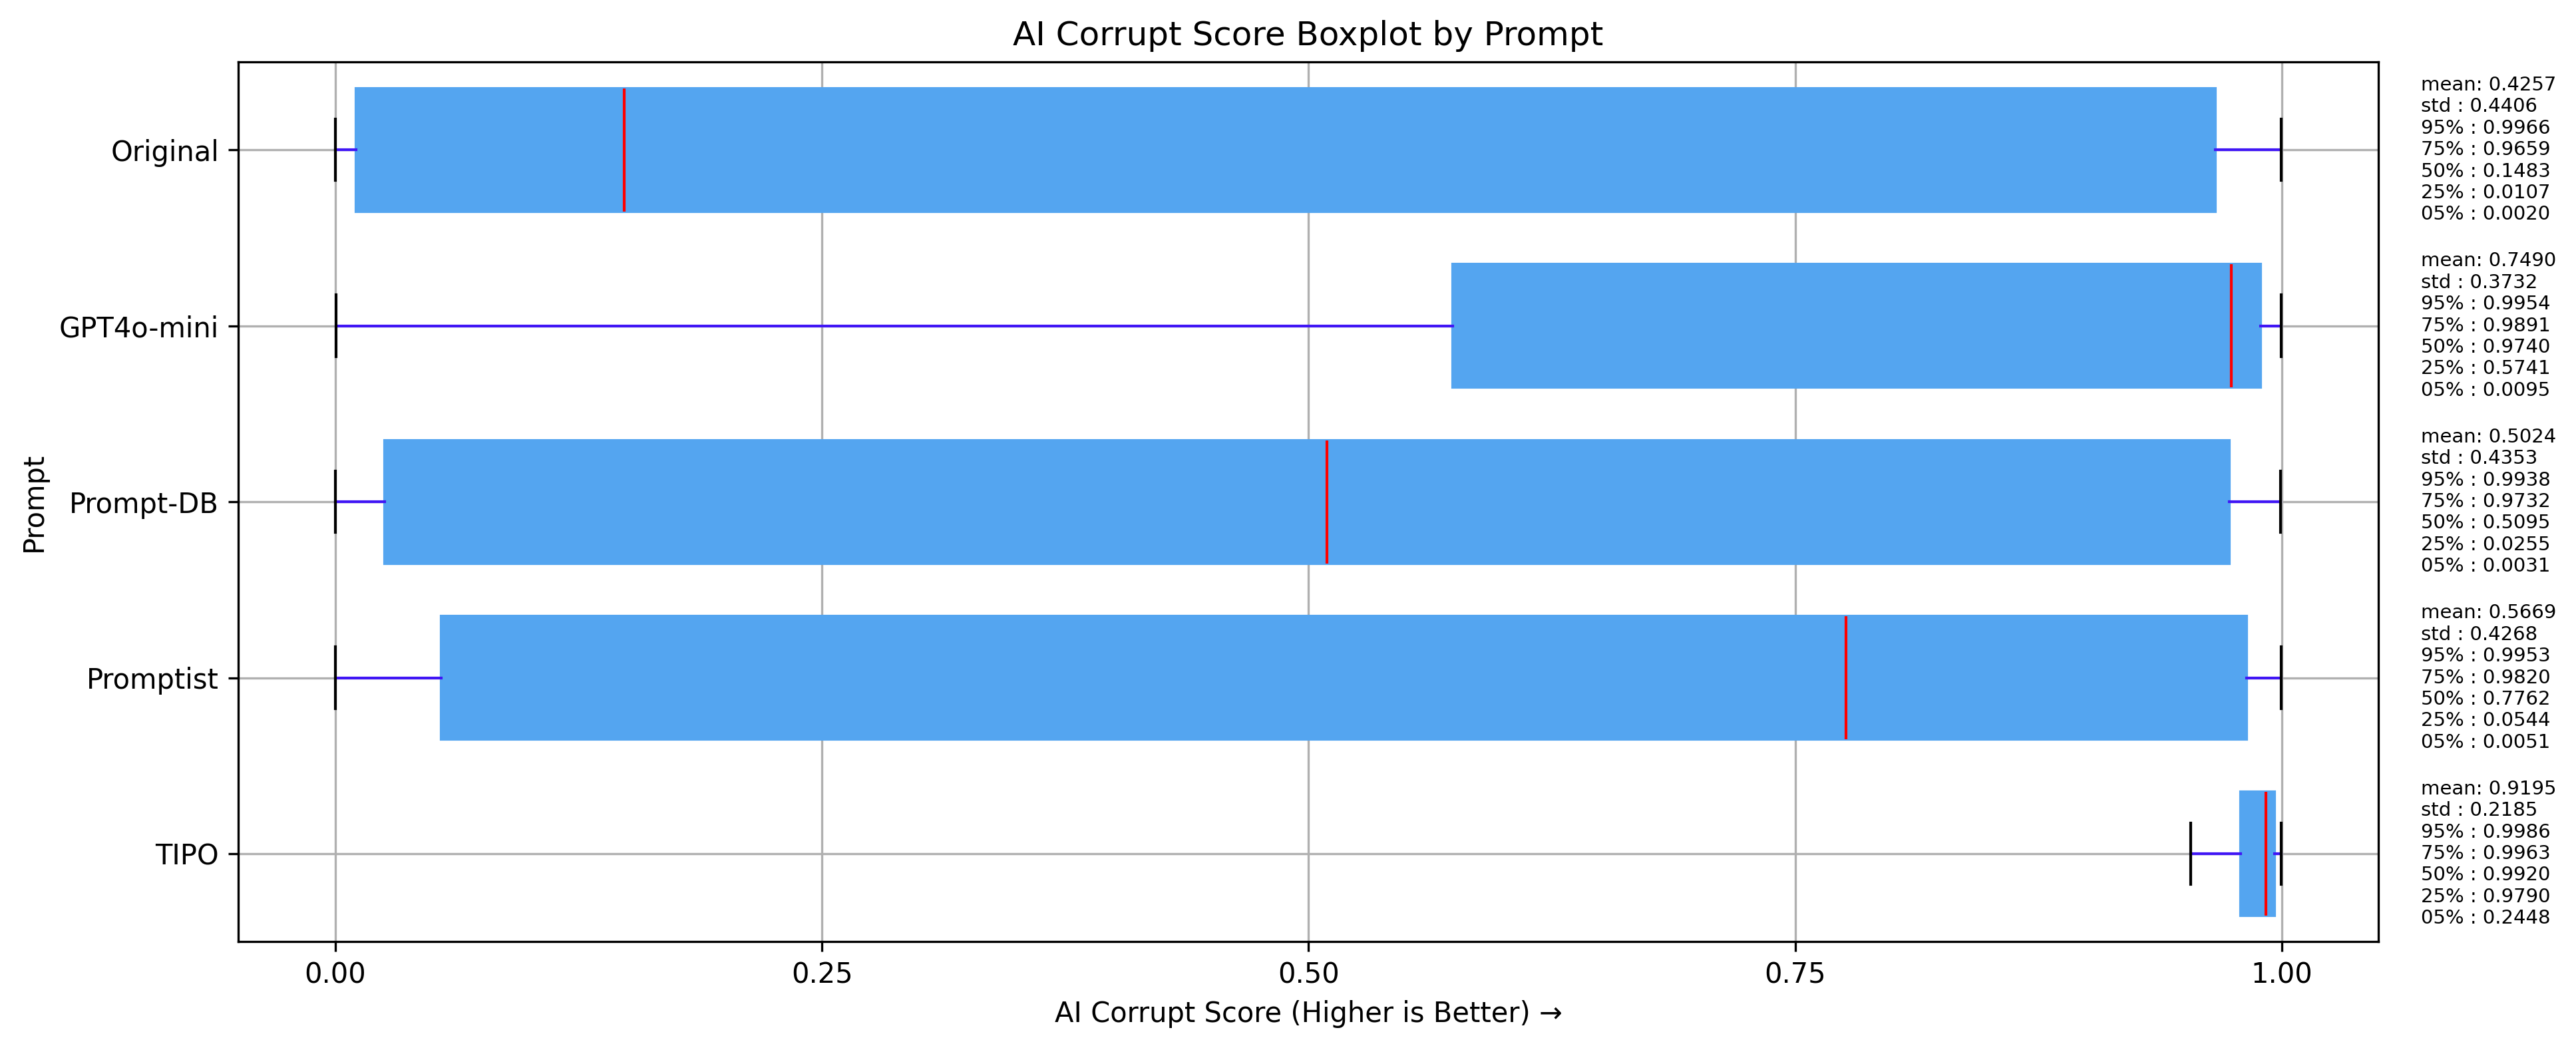


Quantiles for each model:
model           
TIPO        0.05    0.244770
            0.25    0.979027
            0.50    0.992001
            0.75    0.996257
            0.95    0.998599
Promptist   0.05    0.005081
            0.25    0.054427
            0.50    0.776204
            0.75    0.982029
            0.95    0.995298
Prompt-DB   0.05    0.003089
            0.25    0.025454
            0.50    0.509466
            0.75    0.973212
            0.95    0.993813
GPT4o-mini  0.05    0.009492
            0.25    0.574131
            0.50    0.973962
            0.75    0.989066
            0.95    0.995411
Original    0.05    0.001967
            0.25    0.010693
            0.50    0.148281
            0.75    0.965909
            0.95    0.996567
Name: ai_corrupt, dtype: float64


In [30]:
# Calculate statistics for sorting
df_stats = (
    df.groupby("model").agg({"ai_corrupt": ["mean", lambda x: x.mean()]}).reset_index()
)
df_stats.columns = ["model", "mean", "ai_corrupt"]

# Choose sorting method (uncomment the desired method)
# df_stats_sorted = df_stats.sort_values('median', ascending=False)
df_stats_sorted = df_stats.sort_values("mean", ascending=False)

# Sort the original dataframe based on the stats
df_sorted = df.set_index("model").loc[model_order].reset_index()
# print(df_stats)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(13, 5.5), dpi=300)

df_sorted["model"] = pd.Categorical(
    df_sorted["model"],
    categories=reversed(list(df_sorted["model"].unique())),
    ordered=True,
)
positions = [i * y_scale for i in range(len(model_order))]
# Create the horizontal boxplot using the sorted data
boxplot = df_sorted.boxplot(
    column="ai_corrupt",
    by="model",
    vert=False,
    ax=ax,
    patch_artist=True,
    medianprops={"color": "red"},
    showfliers=False,
    color={
        "boxes": "#54A5F0",
        "whiskers": "#4016F5",
        "medians": "red",
        "caps": "black",
    },
    positions=positions,
    widths=[box_scale] * len(model_order),
)

# Customize the plot
ax.set_title("AI Corrupt Score Boxplot by Prompt")
ax.set_ylabel("Prompt")
ax.set_xlabel("AI Corrupt Score (Higher is Better) →")

# Remove the automatically generated suptitle
plt.suptitle("")

# Adjust the y-axis tick labels
plt.yticks(rotation=0)

# Adjust the data range and tick marks
min_score = df["ai_corrupt"].min()
max_score = df["ai_corrupt"].max()
range_margin = (max_score - min_score) * 0.05
# ax.set_xlim(-1.5, 1.5)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))

# Calculate and add quantile information
quantiles = df_sorted.groupby("model")["ai_corrupt"].quantile(
    [0.05, 0.25, 0.5, 0.75, 0.95]
)
reverse_map = {
    v1: v2
    for v1, v2 in zip(
        df_sorted["model"].unique(), reversed(df_sorted["model"].unique())
    )
}

means = df_sorted.groupby("model")["ai_corrupt"].mean()
std = df_sorted.groupby("model")["ai_corrupt"].std()

# print(quantiles)
for i, model in enumerate(df_sorted["model"].unique()):
    model = reverse_map[model]
    quantile_text = (
        f"mean: {means.loc[model]:.4f}\n"
        f"std : {std.loc[model]:.4f}\n"
        f"95% : {quantiles.loc[model, 0.95]:.4f}\n"
        f"75% : {quantiles.loc[model, 0.75]:.4f}\n"
        f"50% : {quantiles.loc[model, 0.50]:.4f}\n"
        f"25% : {quantiles.loc[model, 0.25]:.4f}\n"
        f"05% : {quantiles.loc[model, 0.05]:.4f}"
    )
    ax.annotate(
        quantile_text,
        xy=(1.02, i * y_scale),
        xycoords=("axes fraction", "data"),
        va="center",
        ha="left",
        fontsize=7,
    )

# Display the plot
plt.tight_layout()
plt.show()

# Log quantile information
print("\nQuantiles for each model:")
print(quantiles)